In [1]:
import pickle
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import os
import requests
import json
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib
import getpass
import warnings
import pandas
import time
import subprocess
import logging
import webbrowser
import glob
from datetime import *
import scipy.signal
from os import listdir
import sqlite3

np.random.seed(1)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [2]:
"""Read in the file containing a list of the sources you are interested in along with their redshifts, in two columns
    """

f = ascii.read("SLSNe - I copy.txt") #ascii file containing the names of sources and their redshifts
targets = f['col1']
redshift = f['col2']

In [3]:
def fetch_ZTF_spectrum(target_id, user, passw, specfilter=False, program_idx=0):
    """Returns list of all available spectra(data url paths) for a given ZTF target.

    Input
    ------
    target_id: ZTF name of source (str)
    user: Username for login cridentials for GROWTH Marshall (str)
    passw: Password for login cridentials for GROWTH Marshall (str)
    specfilter: True; Choose a single spectrum based of of the peak magnitude (PM) (+7 days after PM or -4 before PM) (bool)
    specfilter: False; Choose multiple spectra uploaded in the Marshall (bool)

    Output
    ------
    list_spec: List of download paths (from marshall) in format: spectra/data/ZTFid_date_inst_vn.ascii (list)
    """

    programidx = program_idx # Superluminous: 10
    r = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi', auth=(user, passw), data = {'programidx': str(programidx)})
    sources = json.loads(r.text) # preliminary information on CLU objects
    list_spec, sd, dat_url, dat_inst = [], [], [], []

    for i in enumerate(sources_clu):
        name = i[1]['name'] # name generated from marshall

        if name == target_id: # if you find the ZTF_id you have queried
            marsh_info = i[1] # fetch marshall information!
            s = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/source_summary.cgi', auth=(user, passw), data = {'sourceid': str(marsh_info['id'])})
            sourceDict = json.loads(s.text)

            # Spectral and Photometric information --
            spec = sourceDict['uploaded_spectra'] # information on spectroscopy
            photometry_info = sourceDict['uploaded_photometry'] # information on photometry

            N_spec = len(spec) # number of available spectra! -- check for uniqueness? [NOTE!]
            
            for spectra_path in spec:
                list_spec.append(str(spectra_path['datapath'])) # append datapaths...
            return (list_spec)

In [4]:
def download_spectra(data_path, target_id, date_dir_name, dtype='no_header'):
    """Downloads .ascii files from GROWTH Marshall for given ZTF object.

    Input
    -----
    data_path: Download URL from GROWTH Marshall -- usually called from Fetch_ZTF_Spectrum (str)
    target_id: ZTF name of source (str)
    date_dir_name: daving date directory you will be storing the downloaded files (str)
    dtype: data type you want for the ascii files. Usually no_header will not read the first row of the ascii file.

    Output
    ------
    Creates /spectra and /summary directories and downloads ascii file data path given.

    """
    # GROWTH Marshall url where data is available
    download_url = "http://skipper.caltech.edu:8080/growth-data/"

    # Complete path to url downloading data
    data_path_mod = data_path.split("/")[2].split('.')[0] #ZTFid_date_inst_vn

    try:
        # Stich final directories to the directory containing the data
        final_path_to_data = download_url + "spectra/data/" + data_path_mod + ".ascii"
        #print ("this is the final path --> ")
        #print (final_path_to_data)
    except:
        #print ("This file you have requested is not available!")
        return (None)

    # Make a new directory with the ZTF name
    bash1 = subprocess.run("mkdir data/%s/%s"%(date_dir_name, target_id), shell=True)
    bash2 = subprocess.run("mkdir data/%s/%s/spectra"%(date_dir_name, target_id), shell=True) # create the spectra dir in the ZTF target dir

    # Fetch data from custom url
    data = ascii.read("%s"%final_path_to_data, format=dtype)
    # clean from nan values
    rmv_nan = np.where(np.isnan([data['col1'], data['col2']]))
    data.remove_rows(rmv_nan[1]) # will remove NaN identified values!
    min_lambda = min(data['col1']) # minimum wavelength
    max_lambda = max(data['col1'])# maximum wavelength

    # Generally in this directory we will have: ".asii", ".output"
    download_spectrum = ascii.write(data, "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod), format=dtype)
    stored_spectrum = "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod)
    return (stored_spectrum)

In [40]:
def plot_smoothed_spectra(a, b, constant, low_xlim, up_xlim, low_ylim, up_ylim, fig_name):
    
    """Returns a plot of all the spectra arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    a: index of the source in the list to start plotiing from (int)
    b: index of the source in the list to end plotiing at (int)
    constant: adds a constant to the calculated flux, value changes for every spectrum to shift them down on the 
    Y axis, to avoid overlap, hange value for an even distribution about zero (int)
    low_xlim: lower limit of x-axis (int)
    up_xlim: upper limit of x-axis (int)
    low_ylim: lower limit of y-axis (int)
    up_ylim": upper limit of y-axis (int)
    fig_name: Name the pdf of the plot created (str)
    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """

    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    for t in targets[a:b]: # Go through the list of ZTFnames in the ascii file
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source

            l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
            #print (l)    

            inst = l.split("_")[2]
            instrument.append(inst)

            date = l.split("_")[1]      # store just the date from the spectrum name
            #print (date)     

            new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
            #print (new_date)  

            normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

            Julian_date = normal_date.mjd #convert to MJD

            label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
            #print (label)    
            
            text.append(label)    #append all the labels to an array to use later

            data = ascii.read(d)    #read in the ascii file
            data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

            # Removing all the rows where either of the values is nan
            data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
            data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

            #Scaling the flux values here
            lam_cut = np.where((data_l>6000) & (data_l<7000))

            #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
            mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

            plotx.append(data_l)
            ploty.append(data_flux/mean) #Scaling flux for plotting

    #print (instrument)

    fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
    ax.set_xlim(low_xlim,up_xlim)
    ax.set_ylim(low_ylim,up_ylim)
    plt.xlabel('Rest Wavelength Å')
    plt.ylabel('Scaled Flux + Constant')
    #plt.yscale('log')

    const = constant   #increment
    count = 0 #increment
    inc = 0
    name = fig_name
    
    for k in zip(plotx,ploty):

        #print(instrument[inc])

        if instrument[inc] == "Keck1": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter

        elif instrument[inc] == "Keck2": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument[inc] == "P200":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument[inc] == "P60":
            yhat = scipy.signal.savgol_filter(k[1], 31, 4)

        elif instrument[inc] == "LT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 4)

        elif instrument[inc] == "NOT":
            yhat = scipy.signal.savgol_filter(k[1], 35, 3) 

        elif instrument[inc] == "VLT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument[inc] == "DCT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument[inc] == "WHT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument[inc] == "NTT":
            yhat = scipy.signal.savgol_filter(k[1], 35, 3)

        # Plotting the spectrum name and date for every spectrum
        y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
        text_pos_y = np.median(y_temp)    # defining the location on y-axis
        ax.text(7200, (text_pos_y), text[count], size=12) 

        #print (text[count])
        variable = text[count][0]    # Only select the name of sourcec by indexing
        #print (variable)
        r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
        z = (1 + r)

        ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
        ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

        inc += 1
        count = count+1  #to go through the Text array and print appropriate text besides every spectra
        const += -2    #shift the spectra
        
        
    # Make a new directory to save the plots   
    bash1 = subprocess.run("mkdir plots", shell=True)    
    plt.savefig("plots/%s"%name, format = 'pdf', bbox_inches = 'tight')
    plt.show()

In [6]:
user = "AishwaryaD"   #Marshal Username
passw = "bBrA@7592"   #Marshal Password
program_index = "10"  #program id for the program which contains the candidates you are interested in, 
                      #same program has different id for every different user 

# Where will the data be stored from this python run? 
date_directory= "new"#input
mkdir_date_dir = os.system("mkdir data/%s"%date_directory) # make a new directory where we will store the datapath


for target in targets:
    print (target)
    
    spectra = fetch_ZTF_spectrum(target, user, passw, program_idx=10) # Get the URLs of all available spectra for a source
    print (spectra)
    
    for spec in spectra:
        spec_download = download_spectra(spec, target, date_directory) # download all spectra to data path
        print (spec_download)
       
    out_files_path = glob.glob("data/%s/%s/spectra/*.ascii"%(date_directory, target))

ZTF18abszecm
['spectra/data/ZTF18abszecm_20181213_P200_v3.ascii', 'spectra/data/ZTF18abszecm_20180913_P200_v1.fits', 'spectra/data/ZTF18abszecm_20181213_P200_v1.ascii', 'spectra/data/ZTF18abszecm_20181111_Keck1_v1.ascii', 'spectra/data/ZTF18abszecm_20190829_Keck1_v2.ascii', 'spectra/data/ZTF18abszecm_20190702_Keck1_v1.ascii']
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20181213_P200_v3.ascii
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20180913_P200_v1.ascii
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20181213_P200_v1.ascii
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20181111_Keck1_v1.ascii
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20190829_Keck1_v2.ascii
data/new/ZTF18abszecm/spectra/ZTF18abszecm_20190702_Keck1_v1.ascii
ZTF18acenqto
['spectra/data/ZTF18acenqto_20181209_P60_v1.ascii', 'spectra/data/ZTF18acenqto_20181201_Keck1_v1.ascii', 'spectra/data/ZTF18acenqto_20190126_NOT_v1.fits', 'spectra/data/ZTF18acenqto_20181212_P60_v1.ascii', 'spectra/data/ZTF18acenqto_20181213_P200_v1.fits', 'sp

data/new/ZTF18aazgrfl/spectra/ZTF18aazgrfl_20190104_Keck1_v1.ascii
data/new/ZTF18aazgrfl/spectra/ZTF18aazgrfl_20180714_WHT_v1.ascii
data/new/ZTF18aazgrfl/spectra/ZTF18aazgrfl_20190304_Keck1_v1.ascii
ZTF18abjwagv
['spectra/data/ZTF18abjwagv_20180819_P60_v1.ascii', 'spectra/data/ZTF18abjwagv_20180819_P60_v2.ascii', 'spectra/data/ZTF18abjwagv_20180813_P200_v1.ascii', 'spectra/data/ZTF18abjwagv_20190307_Keck1_v1.ascii']
data/new/ZTF18abjwagv/spectra/ZTF18abjwagv_20180819_P60_v1.ascii
data/new/ZTF18abjwagv/spectra/ZTF18abjwagv_20180819_P60_v2.ascii
data/new/ZTF18abjwagv/spectra/ZTF18abjwagv_20180813_P200_v1.ascii
data/new/ZTF18abjwagv/spectra/ZTF18abjwagv_20190307_Keck1_v1.ascii
ZTF18ablwafp
['spectra/data/ZTF18ablwafp_20180902_P60_v1.ascii', 'spectra/data/ZTF18ablwafp_20180918_P60_v1.ascii', 'spectra/data/ZTF18ablwafp_20180918_LT_v1.ascii', 'spectra/data/ZTF18ablwafp_20181006_P200_v1.ascii', 'spectra/data/ZTF18ablwafp_20190702_Keck1_v1.ascii']
data/new/ZTF18ablwafp/spectra/ZTF18ablwafp_201

TypeError: 'NoneType' object is not iterable

ZTF18abszecm
ZTF18acenqto
ZTF18acxgqxq
ZTF19aarphwc
ZTF19aawsqsc


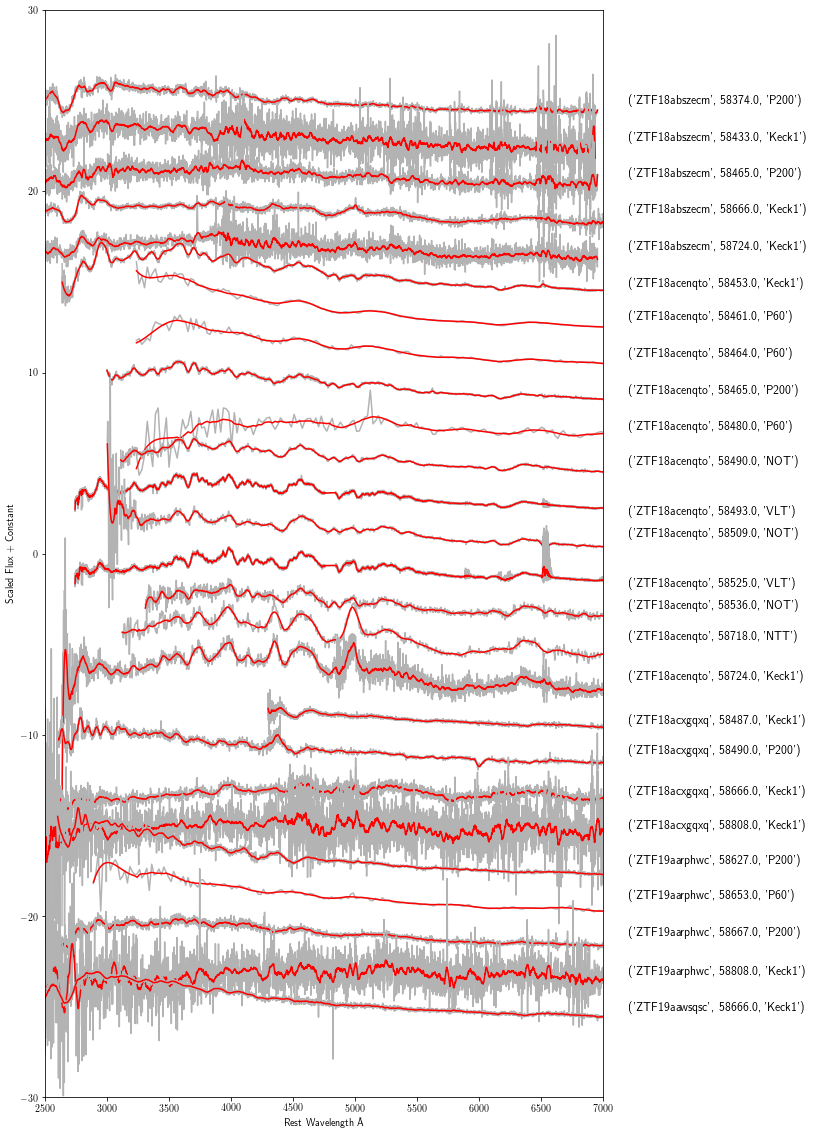

In [41]:
fig_name = "fig1"
plot_smoothed_spectra(0, 5, 24, 2500, 7000, -30, 30, fig_name)

ZTF19aavouyw
ZTF19aaqrime
ZTF19abaeyqw
ZTF18aajqcue
ZTF18aavrmcg


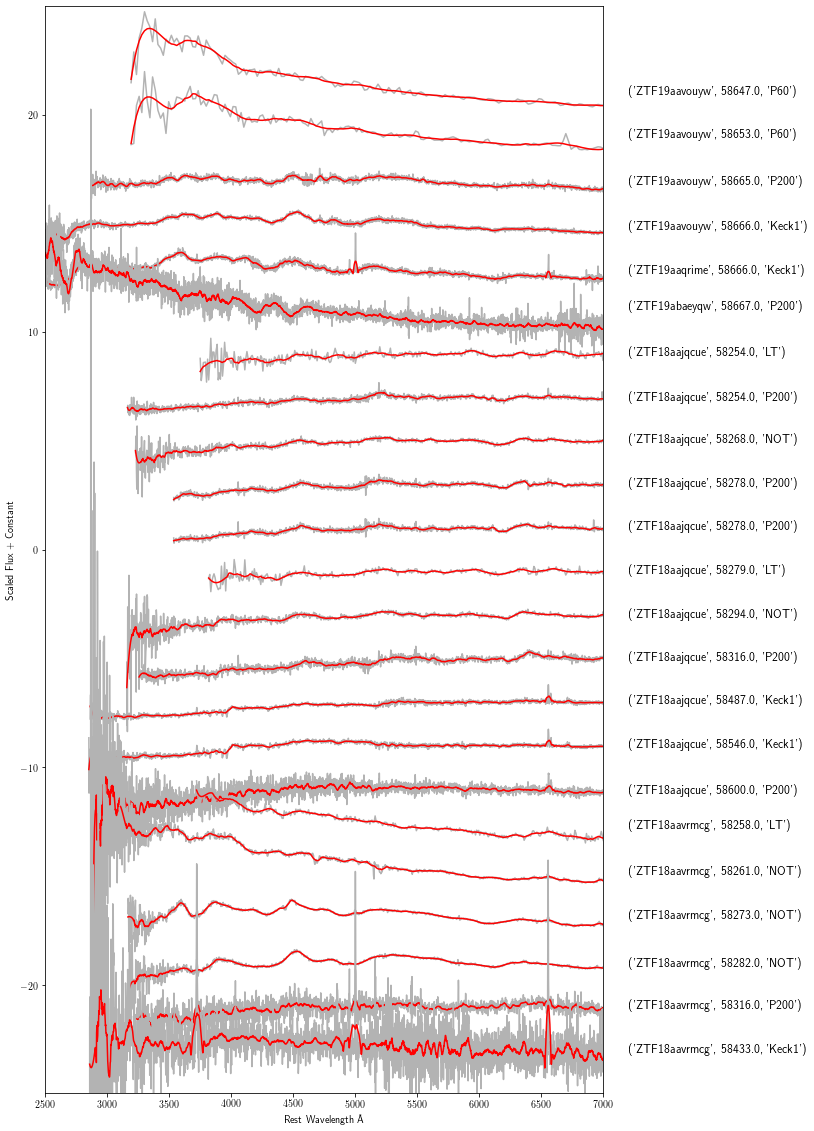

In [42]:
fig_name = "fig2"
plot_smoothed_spectra(5, 10, 20, 2500, 7000, -25, 25, fig_name)

ZTF18aazgrfl
ZTF18abjwagv
ZTF18ablwafp
ZTF18abmasep
ZTF18abshezu


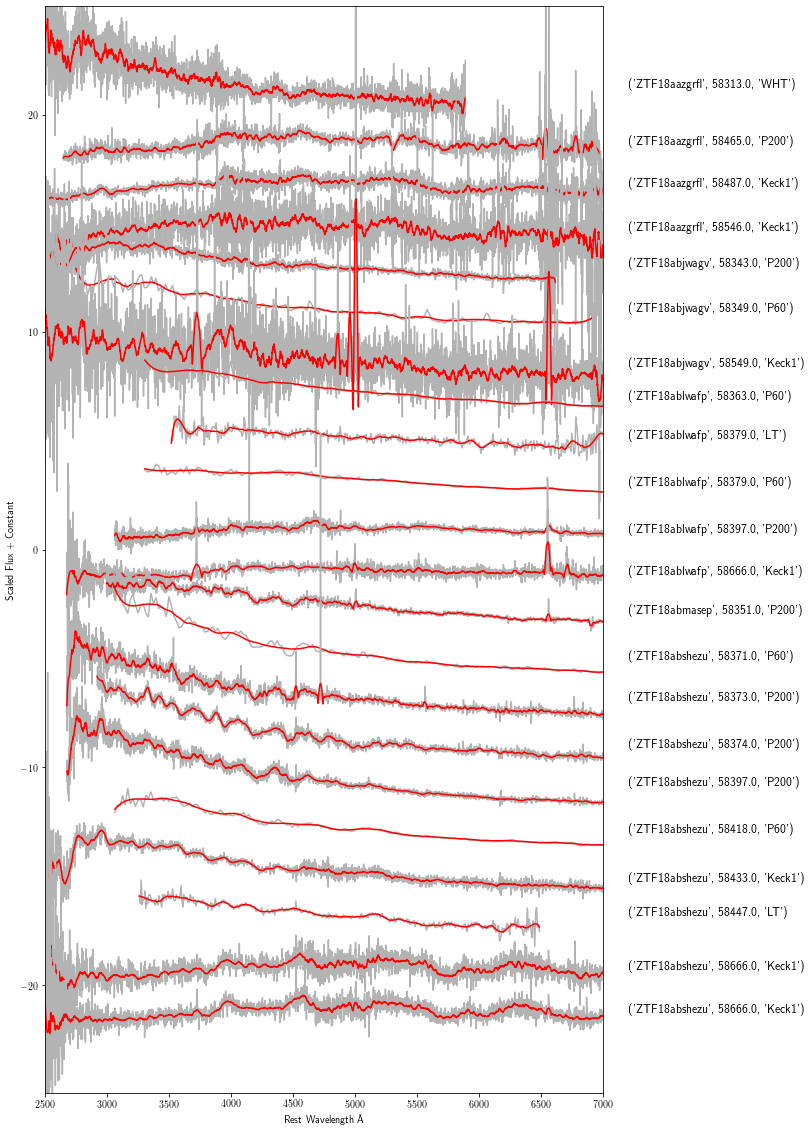

In [43]:
fig_name = "fig3"
plot_smoothed_spectra(10, 15, 20, 2500, 7000, -25, 25, fig_name)

ZTF18abvgjyl
ZTF18acapyww
ZTF18achdidy
ZTF18acqyvag
ZTF18acslpji


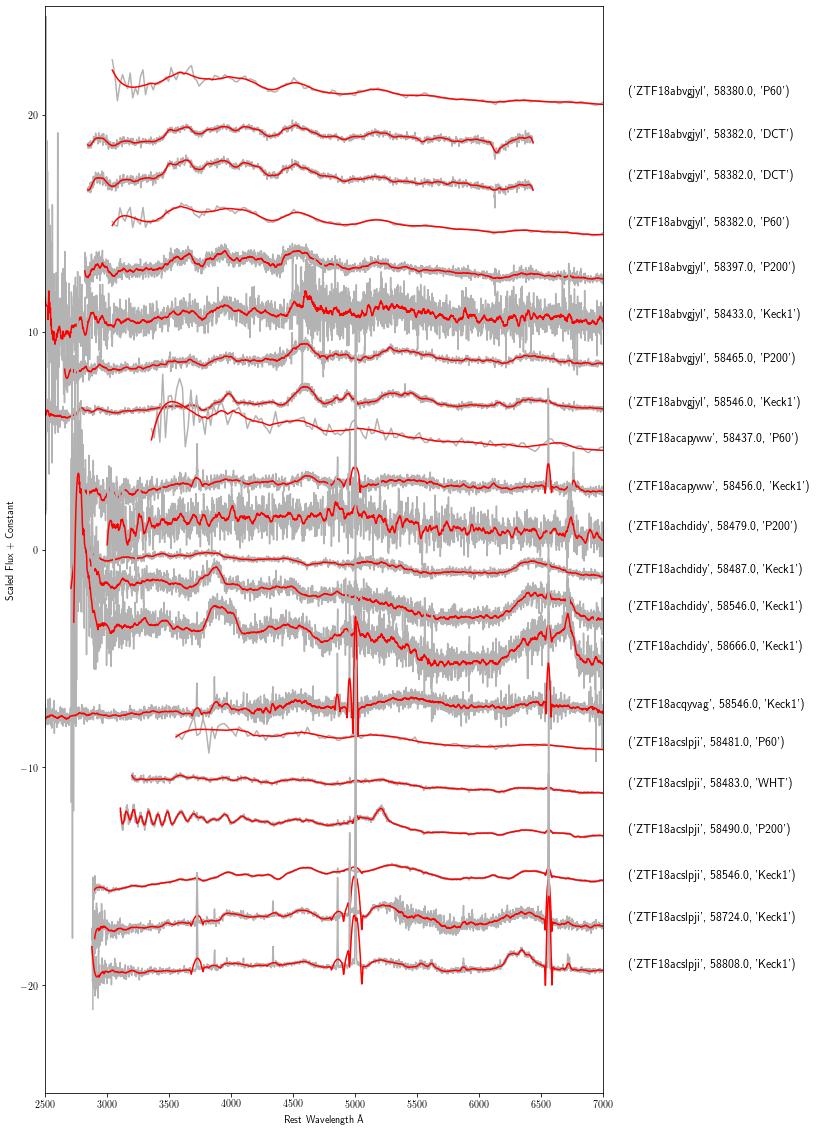

In [44]:
fig_name = "fig4"
plot_smoothed_spectra(15, 20, 20, 2500, 7000, -25, 25, fig_name)

ZTF18acyxnyw
ZTF19aacxrab
ZTF19aajwogx
ZTF19aaknqmp
ZTF19aalbrph


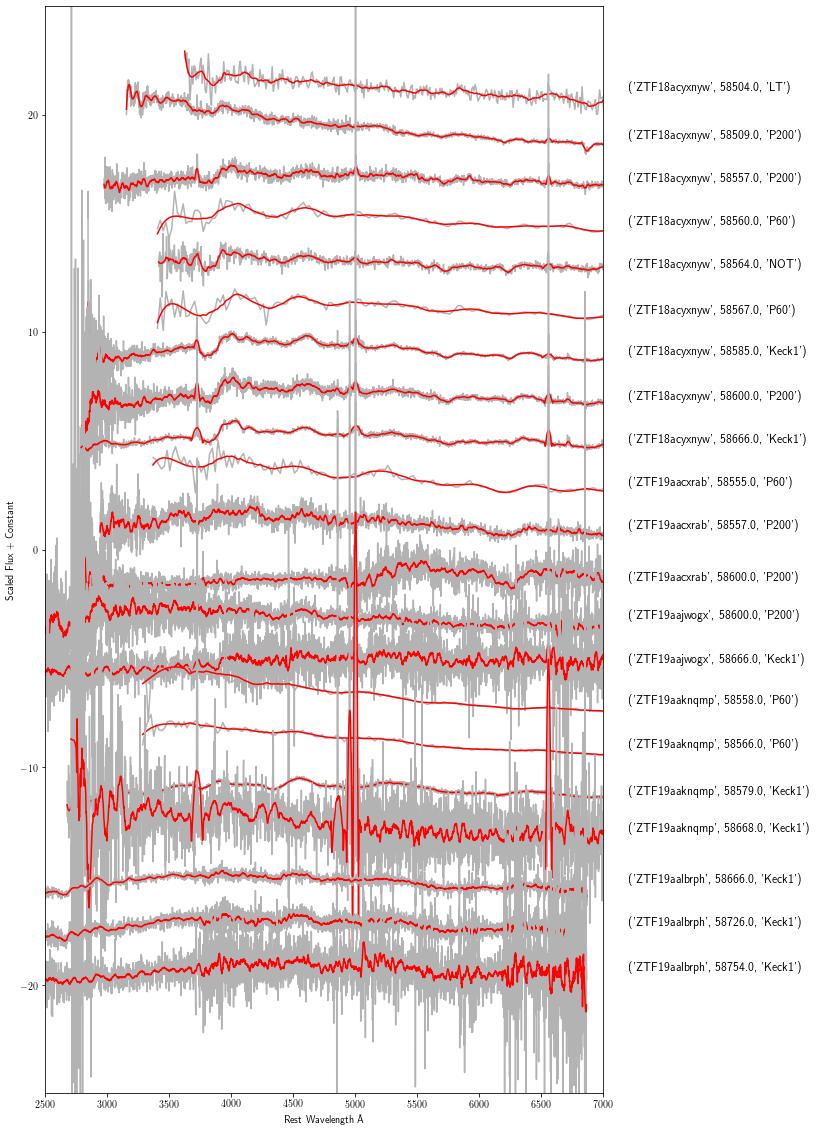

In [45]:
fig_name = "fig5"
plot_smoothed_spectra(20, 25, 20, 2500, 7000, -25, 25, fig_name)

ZTF19aamhhiz
ZTF19aantokv
ZTF19aaohuwc
ZTF19aapaeye
ZTF19aaruixj
ZTF19aasdvfr
ZTF19aauiref
ZTF19aayclnm
ZTF19abdlzyq
ZTF19abfvnns


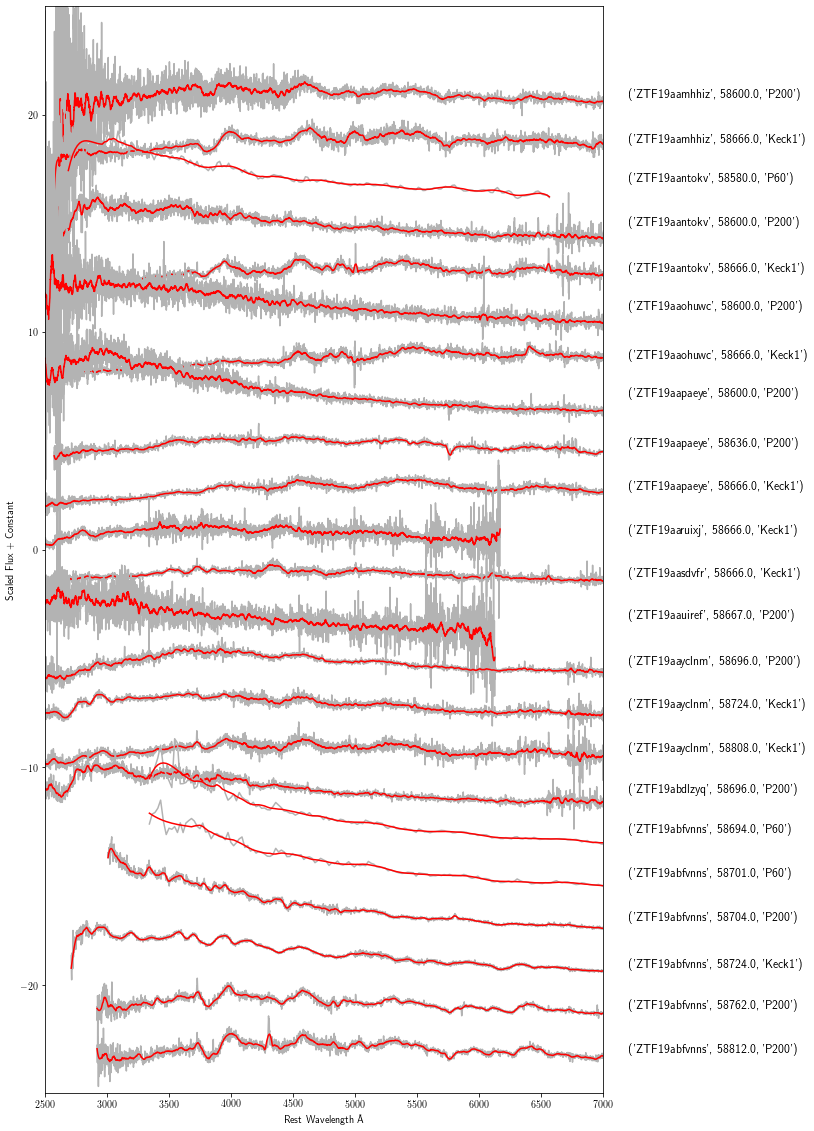

In [46]:
fig_name = "fig6"
plot_smoothed_spectra(25, 36, 20, 2500, 7000, -25, 25, fig_name)

In [ ]:
sorted

In [86]:
plotx = []
ploty = []

plotx_new = []
ploty_new = []

label = [[],[]]
text = []
rest = []
instrument = []
julian = []

for t in targets[15:20]: # Go through the list of ZTFnames in the ascii file
    print(t)

    directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

    for d in directory: # go through all the spectra

        l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
        #print (l)     #check if working

        inst = l.split("_")[2]
        instrument.append(inst)

        date = l.split("_")[1]      # store just the date from the spectrum name
        #print (date)     #check if working

        new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
        #print (new_date)  #check if working

        normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

        Julian_date = normal_date.mjd #convert to MJD
        #print(Julian_date)
        julian.append(Julian_date)
        
        label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
        text.append(label)    #append all the labels to an array to use later

        data = ascii.read(d)    #read in the ascii file
        data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

        # Removing all the rows where either of the values is nan
        data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
        data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

        #Scaling the flux values here
        lam_cut = np.where((data_l>6000) & (data_l<7000))

        #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
        mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

        plotx.append(data_l)
        ploty.append(data_flux/mean) #Scaling flux for plotting
    
    print(julian)
    sort = np.argsort(julian)
    print (sort)
    
print (instrument)

ZTF18abvgjyl
[58380.0, 58382.0, 58382.0, 58382.0, 58397.0, 58433.0, 58465.0, 58546.0]
[0 1 2 3 4 5 6 7]
data/new/ZTF18abvgjyl/spectra/ZTF18abvgjyl_20190304_Keck1_v1.ascii
ZTF18acapyww
[58380.0, 58382.0, 58382.0, 58382.0, 58397.0, 58433.0, 58465.0, 58546.0, 58437.0, 58456.0]
[0 1 2 3 4 5 8 9 6 7]
data/new/ZTF18acapyww/spectra/ZTF18acapyww_20181204_Keck1_v1.ascii
ZTF18achdidy
[58380.0, 58382.0, 58382.0, 58382.0, 58397.0, 58433.0, 58465.0, 58546.0, 58437.0, 58456.0, 58479.0, 58487.0, 58546.0, 58666.0]
[ 0  1  2  3  4  5  8  9  6 10 11  7 12 13]
data/new/ZTF18achdidy/spectra/ZTF18achdidy_20190702_Keck1_v1.ascii
ZTF18acqyvag
[58380.0, 58382.0, 58382.0, 58382.0, 58397.0, 58433.0, 58465.0, 58546.0, 58437.0, 58456.0, 58479.0, 58487.0, 58546.0, 58666.0, 58546.0]
[ 0  1  2  3  4  5  8  9  6 10 11  7 12 14 13]
data/new/ZTF18acqyvag/spectra/ZTF18acqyvag_20190304_Keck1_v1.ascii
ZTF18acslpji
[58380.0, 58382.0, 58382.0, 58382.0, 58397.0, 58433.0, 58465.0, 58546.0, 58437.0, 58456.0, 58479.0, 58487.0, 

[ 0  1  2  3  4  5  8  9  6 10 15 16 11 17 12 14 18  7 13 19 20]


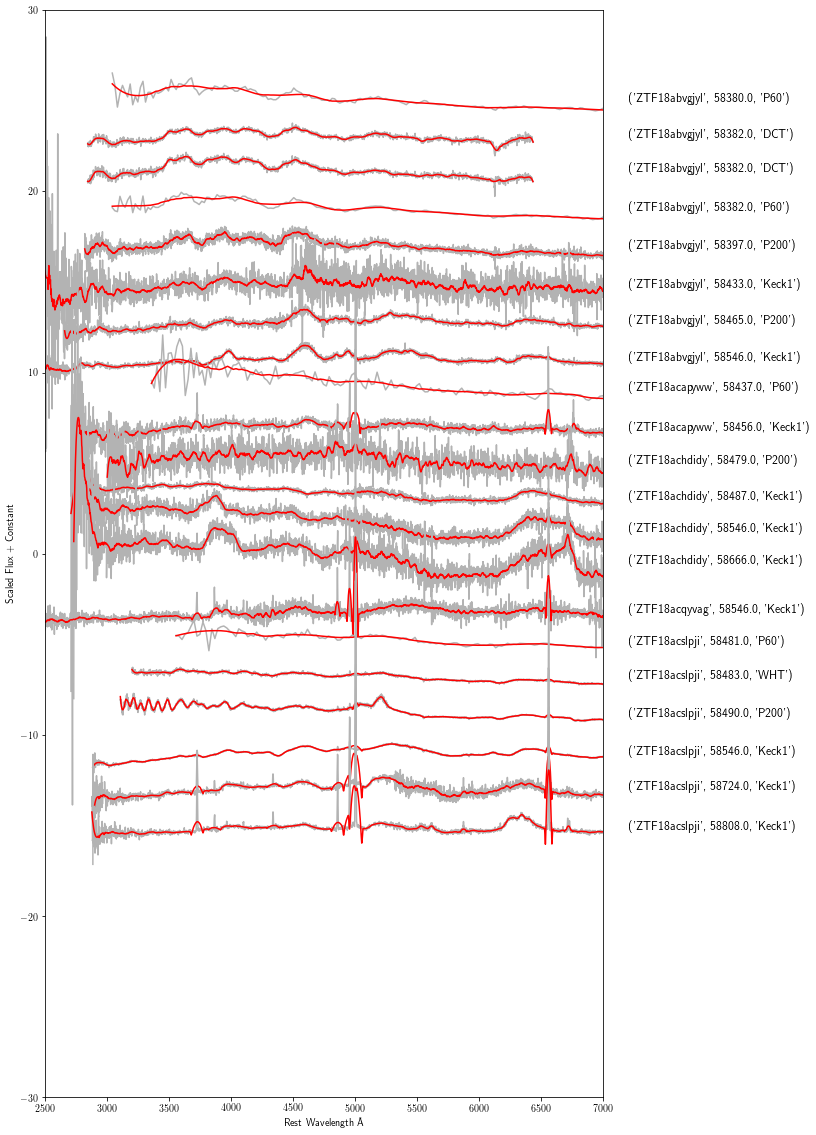

In [82]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
ax.set_xlim(2500,7000)
ax.set_ylim(-30, 30)
plt.xlabel('Rest Wavelength Å')
plt.ylabel('Scaled Flux + Constant')
#plt.yscale('log')

print(sort)
const = 24   #increment
count = 0
inc = 0

for k in zip(plotx,ploty):
    
    #print(k)
    
    if instrument[inc] == "Keck1": 
        yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter
    
    elif instrument[inc] == "Keck2": 
        yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

    elif instrument[inc] == "P200":
        yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

    elif instrument[inc] == "P60":
        yhat = scipy.signal.savgol_filter(k[1], 31, 3)

    elif instrument[inc] == "LT":
        yhat = scipy.signal.savgol_filter(k[1], 31, 4)

    elif instrument[inc] == "NOT":
        yhat = scipy.signal.savgol_filter(k[1], 35, 3) 

    elif instrument[inc] == "VLT":
        yhat = scipy.signal.savgol_filter(k[1], 51, 3)

    elif instrument[inc] == "DCT":
        yhat = scipy.signal.savgol_filter(k[1], 51, 3)

    elif instrument[inc] == "WHT":
        yhat = scipy.signal.savgol_filter(k[1], 51, 3)

    elif instrument[inc] == "NTT":
        yhat = scipy.signal.savgol_filter(k[1], 35, 3)
        
    # Plotting the spectrum name and date for every spectrum
    y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
    text_pos_y = np.median(y_temp)    # defining the location on y-axis
    ax.text(7200, (text_pos_y), text[count], size=12) 

    #print (text[count])
    variable = text[count][0]    # Only select the name of sourcec by indexing
    #print (variable)
    r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
    z = (1 + r)

    ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
    ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

    inc += 1
    count = count+1  #to go through the Text array and print appropriate text besides every spectra
    const += -2    #shift the spectra
    
plt.show()